In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# --- Load .npy image paths and labels ---
def load_npy_images_and_labels(base_dir):
    image_paths, labels = [], []
    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if file.endswith(".npy"):
                    image_paths.append(os.path.join(class_dir, file))
                    labels.append(label)
    return image_paths, labels

In [ ]:
# Define folders
output_train = '/content/drive/MyDrive/MP_AUTISM/Handwriting/Processed_Train'
output_valid = '/content/drive/MyDrive/MP_AUTISM/Handwriting/Processed_Valid'
output_test = '/content/drive/MyDrive/MP_AUTISM/Handwriting/Processed_Test'

In [ ]:
# Load paths and labels
train_paths, train_labels = load_npy_images_and_labels(output_train)
valid_paths, valid_labels = load_npy_images_and_labels(output_valid)
test_paths, test_labels   = load_npy_images_and_labels(output_test)

In [ ]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_valid = le.transform(valid_labels)
y_test  = le.transform(test_labels)
np.save('label_encoder_Handwriting.npy', le.classes_)

In [ ]:
# Load images
def load_images_from_paths(image_paths):
    images = [np.load(p) for p in image_paths]
    return np.array(images)

X_train = load_images_from_paths(train_paths)
X_valid = load_images_from_paths(valid_paths)
X_test  = load_images_from_paths(test_paths)

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

In [ ]:
from tensorflow.keras.optimizers import Adam

# --- Build custom CNN (Ai-NA) ---
def create_AiNA(input_shape,  learning_rate=0.0005):
    inputs = Input(shape=input_shape, name="input_layer")

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten(name="flatten_layer")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name="dense_feature_layer")(x)


    outputs = Dense(len(le.classes_), activation='softmax', name="output_layer")(x)

    model = Model(inputs=inputs, outputs=outputs, name="Ai-NA")

    # Compile the model with custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Create and compile model
input_shape = X_train.shape[1:]  # e.g., (224, 224, 1)
model = create_AiNA(input_shape, learning_rate=0.001) #0.001

# Train model (for feature extraction)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          epochs=20,
          batch_size=32
          #callbacks=[early_stop]
          )

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.2600 - loss: 2.6059 - val_accuracy: 0.2553 - val_loss: 1.3235
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4379 - loss: 1.3006 - val_accuracy: 0.5532 - val_loss: 1.1823
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5387 - loss: 1.1581 - val_accuracy: 0.5532 - val_loss: 1.0505
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6001 - loss: 0.9109 - val_accuracy: 0.6383 - val_loss: 0.8487
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6795 - loss: 0.7713 - val_accuracy: 0.7021 - val_loss: 0.8516
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7948 - loss: 0.5424 - val_accuracy: 0.7021 - val_loss: 0.8544
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8249 - loss: 0.4306 - val_accuracy: 0.6809 - val_loss: 0.9486
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8486 - loss: 0.3846 - val_accuracy: 0.6809 - val_loss: 0.8005
Epoch 9/

In [ ]:
# --- Extract features from the "dense_feature_layer" ---
feature_model = Model(inputs=model.input, outputs=model.get_layer("dense_feature_layer").output)

In [ ]:
X_train_feat = feature_model.predict(X_train)
X_valid_feat = feature_model.predict(X_valid)
X_test_feat  = feature_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 842ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Train RF
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_feat, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict
y_pred_rf = rf_clf.predict(X_test_feat)

In [ ]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

    ASD_Mild       0.80      0.67      0.73         6
ASD_Moderate       0.50      0.83      0.62         6
  ASD_Severe       0.75      0.50      0.60         6
     Non_ASD       1.00      0.80      0.89         5

    accuracy                           0.70        23
   macro avg       0.76      0.70      0.71        23
weighted avg       0.75      0.70      0.70        23



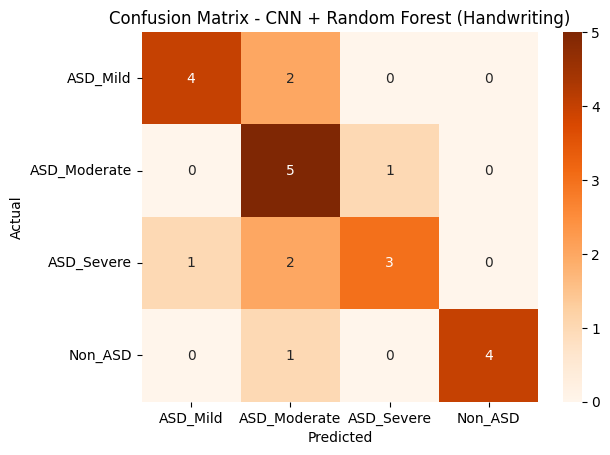

In [ ]:
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN + Random Forest (Handwriting)")
plt.show()

In [ ]:
# Folder where you want to save your files
save_dir = "/content/drive/MyDrive/MP_AUTISM/Handwriting/Models/CNN_RF"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "RF_Handwriting_model.h5")
model.save(model_path)

import joblib

rf_path = os.path.join(save_dir, "rf_Handwriting_model.pkl")
joblib.dump(rf_clf, rf_path)

np.save(os.path.join(save_dir, "label_encoder_Handwriting.npy"), le.classes_)